# Raw Data Extraction

Creating dataset with images and labels from the pure set of videos and the json file.

In [ ]:
from src.data import process_all_splits

In [ ]:
VIDEO_ROOT = "C:\\Users\\sandr\\Downloads\\trailer\\trailer" # Path to the root of the video files
JSON_PATH = "C:\\Users\\sandr\\Downloads\\v1_split_trailer.json" # Path to the json file containing the data information
IMAGE_QUALITY = 15
OUTPUT_DIR = "./data"

In [ ]:
extrac_data = False
if extrac_data:
    process_all_splits(VIDEO_ROOT, JSON_PATH, IMAGE_QUALITY, OUTPUT_DIR) # took 1h and 8 minutes with ≈8frames/s

# Dataset Creation

In [1]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from src.data import LensTypeDataset
from collections import Counter
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
torch.manual_seed(SEED)

In [2]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

noise_stds = [0.05, 0.1, 0.2, 0.4, 0.5]
noise_percentage = 0.3

train_dataset = LensTypeDataset(root_dir="./data", split="train", transform=transform_train,
                                noisy_percentage=noise_percentage, noise_stds=noise_stds, seed=SEED)
val_dataset = LensTypeDataset(root_dir="./data", split="val", transform=transform_val, noisy_percentage=0.0)
test_dataset = LensTypeDataset(root_dir="./data", split="test", transform=transform_val, noisy_percentage=0.0)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [3]:
print(f"Images in train: {len(train_dataset)}")
print(f"Images in val: {len(val_dataset)}")
print(f"Images in test: {len(test_dataset)}")
print(f"Total number of images: {len(test_dataset) + len(val_dataset) + len(train_dataset)}")

Images in train: 20856
Images in val: 4610
Images in test: 8187
Total number of images: 33653


In [4]:
print(f"Train label count: {Counter(train_dataset.labels)}")
print(f"Val label count: {Counter(val_dataset.labels)}")
print(f"Test label count: {Counter(test_dataset.labels)}")

Train label count: Counter({2: 4650, 1: 4529, 3: 4275, 0: 3946, 4: 3456})
Val label count: Counter({1: 1049, 2: 1006, 0: 922, 3: 886, 4: 747})
Test label count: Counter({1: 1792, 2: 1753, 3: 1642, 0: 1641, 4: 1359})


In [5]:
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break

torch.Size([64, 3, 224, 224]) torch.Size([64])


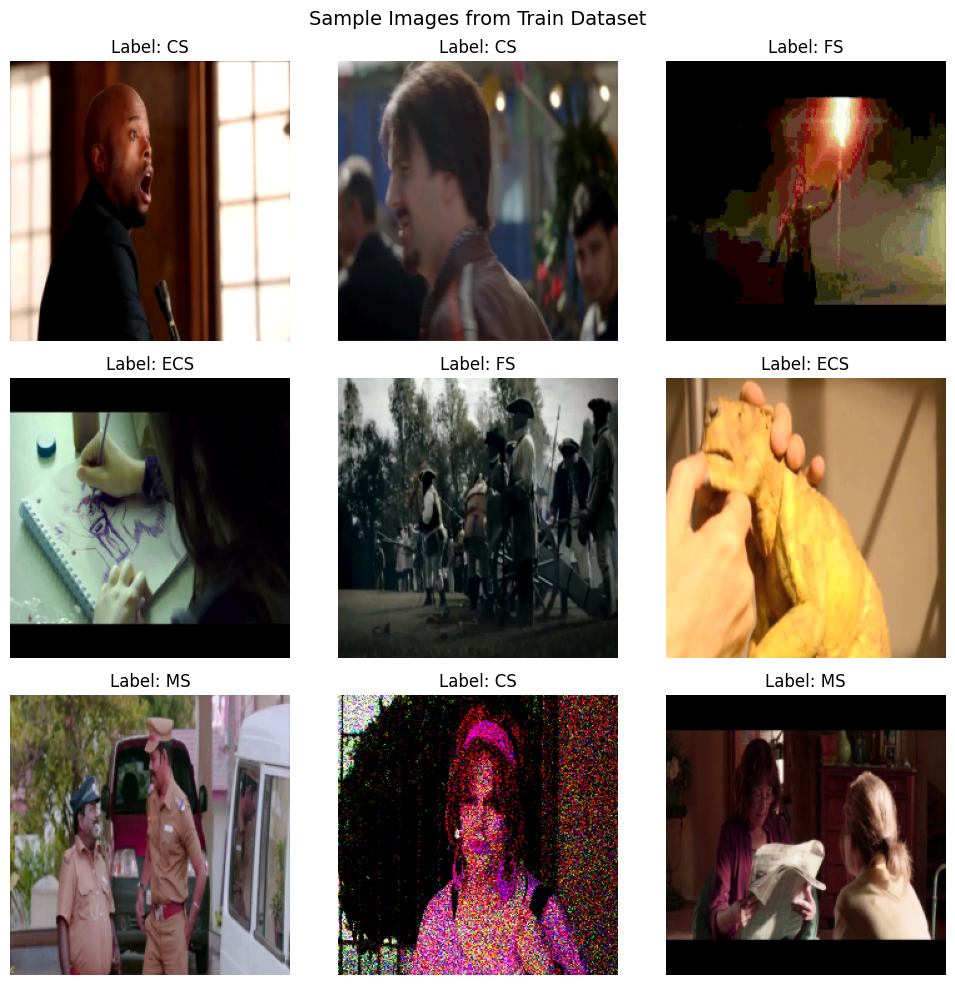

In [6]:
images, labels = next(iter(train_loader))
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
fig.suptitle("Sample Images from Train Dataset", fontsize=14)

label_mapping = {0: "ECS", 1: "CS", 2: "MS", 3: "FS", 4: "LS"}

for i, ax in enumerate(axes.flat):
    img = images[i].permute(1, 2, 0).numpy()  # (C, H, W) to (H, W, C)
    img = (img - img.min()) / (img.max() - img.min())

    ax.imshow(img)
    ax.set_title(f"Label: {label_mapping[labels[i].item()]}")
    ax.axis("off")

plt.tight_layout()
plt.show()

# Finetuning

We perform the finetuning with Optuna. We use a few number of epochs.

In [7]:
import optuna
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

In [8]:
def train_one_epoch(model, train_loader, optimizer, criterion, epoch):
    model.train()
    total_loss, correct = 0, 0
    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    avg_loss = total_loss / len(train_loader)
    acc = correct / len(train_loader.dataset)
    print(f"Train Loss: {avg_loss:.4f}, Train Accuracy: {acc:.4f}")

    return avg_loss, acc

def validate(model, val_loader, criterion):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

    avg_loss = total_loss / len(val_loader)
    acc = correct / len(val_loader.dataset)
    print(f"Val Loss: {avg_loss:.4f}, Val Accuracy: {acc:.4f}")

    return avg_loss, acc

def objective(trial):
    # Suggest hyperparameters:
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-3)
    dropout_rate = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
    
    # Build the model: Fine-tune EfficientNetB3 (only classifier parameters are trainable)
    model = models.efficientnet_b3(pretrained=True)
    # Freeze all layers except the classifier
    for param in model.parameters():
        param.requires_grad = False
    in_feats = model.classifier[1].in_features  # e.g., 1536
    model.classifier = nn.Sequential(
        nn.Linear(in_feats, 512),
        nn.SiLU(inplace=True),
        nn.Dropout(dropout_rate),
        nn.Linear(512, 5)
    )
    for param in model.classifier.parameters():
        param.requires_grad = True
    model = model.to(device)
    
    # Define loss, optimizer, and scheduler.
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    # Using CosineAnnealingLR; adjust T_max as needed (here we set T_max equal to number of epochs)
    epochs_optuna = 3  # training for 3 epochs for speed during hyperparameter search
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs_optuna)
    
    # Train for a few epochs
    for epoch in range(epochs_optuna):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, epoch)
        val_loss, val_acc = validate(model, val_loader, criterion)
        scheduler.step()
    
    # Here we return the validation loss as the objective.
    # (Optuna minimizes by default, and a lower validation loss indicates better performance.)
    return val_loss

In [ ]:
# Create an Optuna study to minimize the objective (validation loss)
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

In [ ]:
# Print the best hyperparameters found
print("Best trial:")
print(study.best_trial)

# Full Training with best Hyperparameters

Now we use the best set of hyperparameters on a full training (more epochs) with early stopping.

In [ ]:
import copy
import torch.optim as optim
import torch.nn as nn
import json

In [ ]:
# Save best hyperparameters from the Optuna study (assume study.best_trial.params exists)
best_hyperparams = study.best_trial.params

In [ ]:
best_hyperparams

In [ ]:
# saving
with open("checkpoints/best_hyperparams.json", "w") as f:
    json.dump(best_hyperparams, f)
print("Best hyperparameters saved.")

In [ ]:
# load the hyperparameters
with open("checkpoints/best_hyperparams.json", "r") as f:
    best_hyperparams = json.load(f)
print("Best hyperparameters loaded:", best_hyperparams)

# Use the best hyperparameters for dropout, learning rate, and weight decay.
# If a hyperparameter is missing in the JSON file, we set a default.
dropout_rate = best_hyperparams.get("dropout_rate", 0.3)
lr = best_hyperparams.get("lr", 3e-4)
weight_decay = best_hyperparams.get("weight_decay", 1e-4)

Best hyperparameters loaded: {'lr': 0.0006609704135552845, 'weight_decay': 3.227705285088108e-05, 'dropout_rate': 0.13979156262153372}


In [ ]:
# Build the model using EfficientNetB3 as in the small fine-tuning code
model = models.efficientnet_b3(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
in_feats = model.classifier[1].in_features  # 1536

model.classifier = nn.Sequential(
    nn.Linear(in_feats, 512),
    nn.SiLU(inplace=True),
    nn.Dropout(dropout_rate),
    nn.Linear(512, 5)
)
for param in model.classifier.parameters():
    param.requires_grad = True
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

# Soft early stopping parameters
patience = 10
min_improvement = 0.001  # minimal decrease in validation loss to be considered an improvement

best_val_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())
epochs_no_improve = 0

num_epochs = 100
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in tqdm(range(num_epochs), desc="Training Epochs"):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, epoch)
    val_loss, val_acc = validate(model, val_loader, criterion)
    scheduler.step()
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Check if validation loss has improved by at least the minimal threshold.
    if best_val_loss - val_loss > min_improvement:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
        print("Validation loss improved. Model saved!")
    else:
        epochs_no_improve += 1
        print(f"No significant improvement for {epochs_no_improve} epochs.")
    
    if epochs_no_improve >= patience:
        print("Early stopping triggered!")
        break

In [ ]:
# Load the best model weights (i.e. those from the epoch with the best validation loss)
model.load_state_dict(best_model_wts)
# Save the final model weights to disk.
torch.save(model.state_dict(), "checkpoints/final_guidance_classifier.pth")
print("Final model saved!")

In [ ]:
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()

## More advanced finetung (to be fixed...)

### **Key Techniques Used**

1. **Hyperparameter Optimization (Optuna)**  
   - Automated the search for optimal hyperparameters like hidden layer dimension, learning rate, weight decay, dropout, and batch size.  
   - Improves model performance without manual trial-and-error.

2. **Advanced Data Augmentation**  
   - **CutMix:** Enhances generalization by mixing images and labels, making the model robust to occlusions and mixed features.  
   - **Noise Injection:** Simulates diffusion process noise to train the classifier on noisy images, aligning with the guidance objective.

3. **Mixed Precision Training (AMP)**  
   - Reduces memory usage and speeds up training while maintaining accuracy through 16-bit floating point computations.  

4. **Stochastic Weight Averaging (SWA)**  
   - Averages weights over training epochs, improving generalization and stability of the model.

5. **Learning Rate Scheduling (CosineAnnealingLR & SWALR)**  
   - Adjusts learning rate dynamically to escape local minima and improve convergence.

6. **Soft Early Stopping**  
   - Monitors validation accuracy and halts training when improvements stagnate, preventing overfitting.

7. **Model & Hyperparameter Saving**  
   - Saves the best model and hyperparameters for reproducibility and further fine-tuning.

### **Why These Techniques?**  
These methods collectively improve model robustness, reduce overfitting, and ensure the classifier can effectively guide the diffusion model—even in the presence of noise. The result is a high-performing model that aligns with the project’s goal of generating synthetic images under various camera settings.

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader
# import torchvision.models as models
# import torchvision.transforms as transforms
# import optuna
# import os
# import numpy as np
# from tqdm import tqdm
# from src.data import LensTypeDataset
# from torch.optim.swa_utils import AveragedModel, SWALR, update_bn
# from torch.cuda.amp import GradScaler, autocast
# import pandas as pd
# import matplotlib.pyplot as plt
# import tqdm as notebook_tqdm

In [ ]:
# # ----------------------------
# # CONFIGURATION & SETUP
# # ----------------------------
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# SEED = 42
# torch.manual_seed(SEED)
# np.random.seed(SEED)

# SAVE_DIR = "./checkpoints"
# OUTPUT_DIR = "./output"
# os.makedirs(SAVE_DIR, exist_ok=True)
# os.makedirs(OUTPUT_DIR, exist_ok=True)

In [ ]:
# # ----------------------------
# # ADVANCED DATA AUGMENTATION
# # ----------------------------
# def cutmix(images, labels, alpha=1.0):
#     """Apply CutMix augmentation."""
#     lam = np.random.beta(alpha, alpha)
#     rand_index = torch.randperm(images.size(0)).to(device)
#     target_a, target_b = labels, labels[rand_index]

#     _, _, H, W = images.size()
#     cx, cy = np.random.randint(W), np.random.randint(H)
#     cut_w, cut_h = int(W * np.sqrt(1 - lam)), int(H * np.sqrt(1 - lam))
#     x1, x2 = np.clip(cx - cut_w // 2, 0, W), np.clip(cx + cut_w // 2, 0, W)
#     y1, y2 = np.clip(cy - cut_h // 2, 0, H), np.clip(cy + cut_h // 2, 0, H)

#     images[:, :, y1:y2, x1:x2] = images[rand_index, :, y1:y2, x1:x2]
#     lam = 1 - ((x2 - x1) * (y2 - y1) / (W * H))
#     return images, target_a, target_b, lam

In [ ]:
# # ----------------------------
# # DATA LOADERS
# # ----------------------------
# def get_loaders(batch_size, noise_probability=0.3, max_noise_std=0.4):
#     transform_train = transforms.Compose([
#         transforms.Resize((224, 224)),
#         transforms.RandomHorizontalFlip(),
#         transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
#         transforms.ToTensor(),
#         transforms.Normalize([0.5]*3, [0.5]*3),
#     ])

#     transform_val = transforms.Compose([
#         transforms.Resize((224, 224)),
#         transforms.ToTensor(),
#         transforms.Normalize([0.5]*3, [0.5]*3),
#     ])

#     train_dataset = LensTypeDataset("./data", split="train", transform=transform_train,
#                                      noisy_percentage=noise_probability, noise_stds=[max_noise_std])
#     val_dataset = LensTypeDataset("./data", split="val", transform=transform_val)

#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
#     return train_loader, val_loader

In [ ]:
# # ----------------------------
# # MODEL DEFINITION
# # ----------------------------
# def build_model(hidden_units, dropout_rate):
#     model = models.efficientnet_b3(pretrained=True)
#     for param in model.parameters():
#         param.requires_grad = False

#     in_feats = model.classifier[1].in_features
#     model.classifier = nn.Sequential(
#         nn.Linear(in_feats, hidden_units),
#         nn.SiLU(inplace=True),
#         nn.Dropout(dropout_rate),
#         nn.Linear(hidden_units, 5)
#     )
#     return model.to(device)

In [ ]:
# # ----------------------------
# # TRAINING AND VALIDATION LOOPS
# # ----------------------------
# def train_one_epoch(model, train_loader, optimizer, criterion, scaler):
#     model.train()
#     total_loss, correct = 0, 0

#     for images, labels in tqdm(train_loader, desc="Training"):
#         images, labels = images.to(device), labels.to(device)

#         if np.random.rand() < 0.5:
#             images, target_a, target_b, lam = cutmix(images, labels)

#         optimizer.zero_grad()
#         with autocast():
#             outputs = model(images)
#             if 'cutmix' in locals():
#                 loss = lam * criterion(outputs, target_a) + (1 - lam) * criterion(outputs, target_b)
#             else:
#                 loss = criterion(outputs, labels)

#         scaler.scale(loss).backward()
#         scaler.step(optimizer)
#         scaler.update()

#         total_loss += loss.item() * images.size(0)
#         correct += (outputs.argmax(1) == labels).sum().item()

#     return total_loss / len(train_loader.dataset), correct / len(train_loader.dataset)

# def validate(model, val_loader, criterion):
#     model.eval()
#     total_loss, correct = 0, 0

#     with torch.no_grad():
#         for images, labels in tqdm(val_loader, desc="Validating"):
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             total_loss += loss.item() * images.size(0)
#             correct += (outputs.argmax(1) == labels).sum().item()

#     return total_loss / len(val_loader.dataset), correct / len(val_loader.dataset)

In [ ]:
# # ----------------------------
# # OPTUNA TUNING
# # ----------------------------
# def objective(trial):
#     lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
#     weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)
#     dropout_rate = trial.suggest_uniform("dropout_rate", 0.2, 0.5)
#     hidden_units = trial.suggest_categorical("hidden_units", [256, 512, 1024])
#     batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

#     train_loader, val_loader = get_loaders(batch_size=batch_size)
#     model = build_model(hidden_units, dropout_rate)
#     criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
#     optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
#     scaler = torch.amp.GradScaler(device=device)

#     best_val_acc = 0
#     for epoch in range(10):
#         train_one_epoch(model, train_loader, optimizer, criterion, scaler)
#         _, val_acc = validate(model, val_loader, criterion)
#         scheduler.step()
#         best_val_acc = max(best_val_acc, val_acc)

#     return best_val_acc

# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=20)

In [ ]:
# # Save best hyperparameters
# best_params = study.best_params
# torch.save(best_params, os.path.join(SAVE_DIR, "best_hyperparams.pt"))
# print("Best hyperparameters saved.")

In [ ]:
# # ----------------------------
# # FINAL TRAINING WITH METRIC TRACKING
# # ----------------------------
# def final_training(best_params, epochs=100, patience=10):
#     train_loader, val_loader = get_loaders(batch_size=best_params['batch_size'])
#     model = build_model(best_params['hidden_units'], best_params['dropout_rate'])
#     criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
#     optimizer = optim.AdamW(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
#     scaler = GradScaler()

#     swa_model = AveragedModel(model)
#     swa_scheduler = SWALR(optimizer, swa_lr=best_params['lr'] / 2)

#     best_val_acc = 0
#     patience_counter = 0

#     train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

#     for epoch in range(epochs):
#         print(f"\nEpoch {epoch+1}/{epochs}")
#         train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, scaler)
#         val_loss, val_acc = validate(model, val_loader, criterion)

#         train_losses.append(train_loss)
#         train_accuracies.append(train_acc)
#         val_losses.append(val_loss)
#         val_accuracies.append(val_acc)

#         if val_acc > best_val_acc:
#             best_val_acc = val_acc
#             patience_counter = 0
#             torch.save(model.state_dict(), os.path.join(SAVE_DIR, "best_model.pth"))
#             print(f"Best model saved with accuracy {best_val_acc:.4f}")
#         else:
#             patience_counter += 1
#             print(f"Patience counter: {patience_counter}/{patience}")
#             if patience_counter >= patience:
#                 print("Early stopping.")
#                 break

#         swa_model.update_parameters(model)
#         swa_scheduler.step()

#     # Update Batch Norm Statistics using SWA Model
#     update_bn(train_loader, swa_model.to(device), device=device)  
#     torch.save(swa_model.state_dict(), os.path.join(SAVE_DIR, "swa_model.pth"))
#     print("✅ SWA Model saved.")

#     # Save metrics to CSV
#     metrics_df = pd.DataFrame({
#         "epoch": list(range(1, len(train_losses) + 1)),
#         "train_loss": train_losses,
#         "train_accuracy": train_accuracies,
#         "val_loss": val_losses,
#         "val_accuracy": val_accuracies
#     })
#     metrics_df.to_csv(os.path.join(OUTPUT_DIR, "training_metrics.csv"), index=False)
#     print("✅ Training metrics saved to 'output/training_metrics.csv'")

In [ ]:
# # Run final training with saved best parameters
# best_params = torch.load(os.path.join(SAVE_DIR, "best_hyperparams.pt"))
# final_training(best_params, epochs=100, patience=10)

In [ ]:
# # ----------------------------
# # PLOTTING METRICS
# # ----------------------------
# metrics_df = pd.read_csv(os.path.join(OUTPUT_DIR, "training_metrics.csv"))

# plt.figure(figsize=(12, 5))
# # Plot Loss
# plt.subplot(1, 2, 1)
# plt.plot(metrics_df['epoch'], metrics_df['train_loss'], label='Train Loss')
# plt.plot(metrics_df['epoch'], metrics_df['val_loss'], label='Val Loss')
# plt.title('Loss over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# # Plot Accuracy
# plt.subplot(1, 2, 2)
# plt.plot(metrics_df['epoch'], metrics_df['train_accuracy'], label='Train Accuracy')
# plt.plot(metrics_df['epoch'], metrics_df['val_accuracy'], label='Val Accuracy')
# plt.title('Accuracy over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.tight_layout()
# plt.show()

# Testing

We evaluate the model on the test set.

In [18]:
import json
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch.nn as nn
import torchvision.models as models

In [ ]:
# load the hyperparameters
with open("checkpoints/best_hyperparams.json", "r") as f:
    best_hyperparams = json.load(f)
print("Best hyperparameters loaded:", best_hyperparams)

dropout_rate = best_hyperparams.get("dropout_rate", 0.13979156262153372)

Best hyperparameters loaded: {'lr': 0.0006609704135552845, 'weight_decay': 3.227705285088108e-05, 'dropout_rate': 0.13979156262153372}


In [11]:
model = models.efficientnet_b3(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
in_feats = model.classifier[1].in_features  # 1536

model.classifier = nn.Sequential(
    nn.Linear(in_feats, 512),
    nn.SiLU(inplace=True),
    nn.Dropout(dropout_rate),
    nn.Linear(512, 5)
)
for param in model.classifier.parameters():
    param.requires_grad = True
model = model.to(device)

c:\Users\sandr\anaconda3\envs\mldl-ecole\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sandr\anaconda3\envs\mldl-ecole\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Load model
model.load_state_dict(torch.load("checkpoints/final_guidance_classifier.pth"))
model.to(device)
model.eval()

C:\Users\sandr\AppData\Local\Temp\ipykernel_19596\3109746264.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("final_guidance_classifier.

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [13]:
# Define test evaluation function
def evaluate_model(model, test_loader):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

In [14]:
# Get predictions on test set
y_pred, y_true = evaluate_model(model, test_loader)

Testing: 100%|██████████| 128/128 [02:33<00:00,  1.20s/it]


In [15]:
# Compute Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.7473


In [16]:
# Compute Classification Report (Precision, Recall, F1-score)
label_names = list(label_mapping.values())  # Extract class names in order
class_report = classification_report(y_true, y_pred, target_names=label_names)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

         ECS       0.80      0.76      0.78      1641
          CS       0.75      0.68      0.71      1792
          MS       0.70      0.73      0.71      1753
          FS       0.77      0.71      0.74      1642
          LS       0.72      0.89      0.80      1359

    accuracy                           0.75      8187
   macro avg       0.75      0.75      0.75      8187
weighted avg       0.75      0.75      0.75      8187



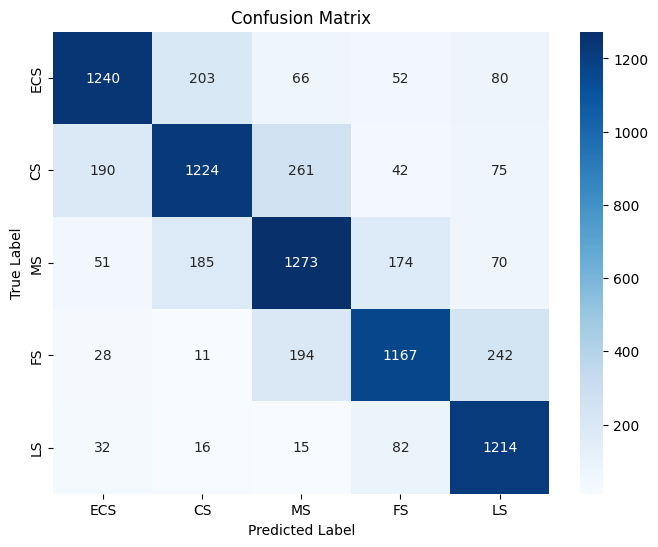

In [17]:
# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, 
            yticklabels=label_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Conclusion: even though the accuracy is not very high (0.74)